# Setup variables for the execution of the test
this notebook executes mcdwt algorythm for 3 videos and plots results comparing sizes of images before and after compression as well as presents the compression ratio for N iterations

In [1]:
#video urls: https://media.xiph.org/video/derf/
#number of frames per video must be greater then 2^N_ITERATIONS

N_ITER=10
SIZE_SUFFIX='KB'
DIR1='/tmp/mcdwt/'
DIR2='/tmp/mcdwt2/'
DIR3='/tmp/mcdwt3/'
VIDEO1='https://media.xiph.org/video/derf/y4m/bridge_close_cif.y4m'
VIDEO2='https://media.xiph.org/video/derf/y4m/bridge_far_cif.y4m'
VIDEO3='https://media.xiph.org/video/derf/y4m/deadline_cif.y4m'

# code
Code to run the test

In [2]:
import shutil
import wget
import sys, getopt
import os
from subprocess import Popen, PIPE, check_output

N_ITERATIONS = 0
VIDEOFILE_NAME = 'test_video'
VIDEOFILE_URL = ''
DEFAULT_DIR = '/tmp/mcdwt/'
TMP_DIR = ''


def do_cleanup(tmp_dir):
   '''
   Clean working directory
   Parameters
   ----------
   tmp_dir - string dir location

   Returns
   -------
   none
   '''
   print('Limpiando directorio de trabajo: %s' % tmp_dir)
   if (os.path.exists(tmp_dir)):
      try:
         shutil.rmtree(tmp_dir)
      except:
         print('Error while deleting directory')
   os.makedirs(tmp_dir, exist_ok=True)


def download_file_to_folder(videofile_url, videofile_name):
   '''
   Download video to location and assign name to videofile
   Parameters
   ----------
   videofile_url - video url
   videofile_name - location and filename for the video

   Returns
   -------

   '''
   print('Descargando archivo: \'%s\' a \'%s\'' % (videofile_url, videofile_name))
   res = wget.download(videofile_url, out=videofile_name)
   print('\n')
   return res


def extract_frames(tmp_dir, gop, videofile):
   '''
   Extract frames using ffmpeg and rename generated images from 001..999 to 000..999
   Files will be placed in directory TMP_DIR/GOP
   Parameters
   ----------
   TMP_DIR - DIRECTORY FOR THE IMAGES
   GOP - GROUP OF IMAGES

   Returns
   -------
   base directory with original images
   '''
   print('Extrayendo %s imagenes a %s' % (str(gop), tmp_dir))
   # ffmpeg -hide_banner -loglevel info -i $file -vframes 9 $folder%03d.png &
   base_dir = tmp_dir + str(gop) + os.sep
   pattern_dir = base_dir + 'original' + os.sep
   os.makedirs(pattern_dir, exist_ok=True)
   pattern = pattern_dir + '%3d.png'
   args = ['ffmpeg', '-hide_banner', '-loglevel', 'info', '-i', videofile, '-vframes', str(gop), pattern]
   execute_command(args)

   # fix frame numbering
   for i in range(1, gop):
      from_file = pattern_dir + str(i).zfill(3) + '.png'
      to_file = pattern_dir + str(i - 1).zfill(3) + '.png'
      shutil.copy(from_file, to_file)

   # remove last file
   rmfile = pattern_dir + str(gop).zfill(3) + '.png'
   os.remove(rmfile)

   # copy originals to res directory where algorythm will be applied
   res_dir = base_dir + 'res' + os.sep
   shutil.copytree(pattern_dir, res_dir)
   return base_dir


def execute_mdwt(image_directory, gop):
   '''
   calls mcdwt algorythm
   Parameters
   ----------
   image_directory - location of the images to process
   gop - group of pictures (number of images to process)

   Returns
   -------
   POPEN object
   '''
   print('Ejecutando MDWT.py para %s imagenes' %str(gop))
   # MDWT.py -N $num_imgs -p /tmp/
   args = ['python3', '-O', 'MDWT.py', '-N', str(gop), '-p', image_directory]
   return execute_command(args)


def execute_mcdwt(image_directory, gop, n_iteration, predictor=1):
   '''

   Parameters
   ----------
   image_directory - location of the images to process
   gop - group of pictures (number of images to process)
   n_iteration - number of iterations
   predictor - predictor value

   Returns
   -------
   POPEN object
   '''
   print('Ejecutando MCDWT.py para imagenes %s, predictor %s, iteraciones %s' %(str(gop), str(predictor), str(n_iteration)))
   # !python3 -O MCDWT.py -N $num_imgs -P $predictor -p /tmp/ -T $iterations
   args = ['python3', '-O', 'MCDWT.py', '-N', str(gop - 1), '-P', str(predictor), '-p', image_directory, '-T',
           str(n_iteration)]
   return execute_command(args)


def execute_command(args, cmd=None, shell=False):
   '''
   executes command in shell
   Parameters
   ----------
   args - command and arguments
   cmd - required for rm command
   shell - popen shell parameter

   Returns
   -------

   '''
   if cmd is None:
      p = Popen(args, stdin=PIPE, stdout=PIPE, stderr=PIPE, shell=shell)
   else:
      p = Popen("%s %s" % (cmd, args), shell=True, stdin=PIPE, stdout=PIPE, stderr=PIPE)
   p.wait()
   return p


def get_dirsize(dir_path, suffix="B"):
   res = int(check_output(['du', '-sb', dir_path]).split()[0].decode('utf-8'))
   print('sizeof: %s: %s' % (dir_path, str(res)))
   return get_size_format(res, suffix=suffix)


def get_size_format(b, suffix="B"):
   '''
   Transform value in bytes (integer) into KB,MB,GB,TB
   Parameters
   ----------
   b - integer value in bytes
   suffix - KB,MB,GB,TB

   Returns
   -------
   integer value in B,KB,MB,GB,TB
   '''
   if isinstance(b, int):
      if suffix == "B":
         pass
      elif suffix == "KB":
         b = int(b / 1024)
      elif suffix == "KB":
         b = int(b / 1024 ** 2)
      elif suffix == "KB":
         b = int(b / 1024 ** 3)
      elif suffix == "KB":
         b = int(b / 1024 ** 4)
      else:
         print('WRONG FORMAT: \'>%s<\', RETURNING KB' % suffix)
   else:
      raise ValueError("var: %s of type: \'%s\' is not an int" % (str(b), type(b)))
   return b

def prepare_current_iteration_directory(tmp_dir, curr_gop, gop):
   '''
   Copy all the images to the directory for the current iteration and remove
   pictures that won't be processed for the current gop number
   Parameters
   ----------
   tmp_dir - working directory
   curr_gop - current gop number
   gop - total gop number

   Returns
   -------
   destination directory (string)
   '''
   srt_dir = tmp_dir + str(gop) + os.sep
   dst_dir = tmp_dir + str(curr_gop) + os.sep
   print('Copiando %s imagenes al directorio: %s' %(str(curr_gop), dst_dir))
   #os.makedirs(tmp_dir, exist_ok=True)
   shutil.copytree(srt_dir, dst_dir)
   #remove extra images
   for i in range(curr_gop, gop):
      rm_file_original = dst_dir + 'original' + os.sep + str(i).zfill(3) + '.png'
      rm_file_res = dst_dir + 'res' + os.sep + str(i).zfill(3) + '.png'
      os.remove(rm_file_original)
      os.remove(rm_file_res)
   return dst_dir

def compress_mcdwt(tmp_dir, videofile_url, n_iterations, predictor=1, suffix='B'):
   '''
   Main function, executes the process of running all the steps to compress images
   and calculate the size of them before and after compression
   Parameters
   ----------
   tmp_dir - working directory to extract images from the video and do processing
   videofile_url - url of the video
   n_iterations - number of iterations for mcdwt
   predictor - predictor value
   suffix - suffix for directory size (default=B,KB,MB,GB)

   Returns
   -------
   Two arrays: original_sizes, compressed sizes
   '''
   global DEFAULT_DIR
   if (tmp_dir == ''): tmp_dir = DEFAULT_DIR
   y_arr = []
   y1_arr = []

   if (n_iterations == 0):
      raise Exception("El número de iteraciones no puede ser igual a 0")
   # cleanup
   do_cleanup(tmp_dir)
   # download file
   videofile = tmp_dir + VIDEOFILE_NAME
   download_file_to_folder(videofile_url, videofile)

   # extract frames ONCE to folder
   all_images_dir = extract_frames(tmp_dir, pow(2, n_iterations), videofile)

   for curr_iteration in range(1, n_iterations + 1):
      curr_gop = pow(2, curr_iteration)
      #prepare directory
      if curr_gop != pow(2, n_iterations):
         curr_dir = prepare_current_iteration_directory(tmp_dir, curr_gop, pow(2, n_iterations))
      else:
         curr_dir = all_images_dir

      # execute MDWT algorythm
      res_dir = curr_dir + 'res' + os.sep
      execute_mdwt(res_dir, curr_gop)
      # execute MCDWT algorythm
      execute_mcdwt(res_dir, curr_gop, curr_iteration, predictor)

      # remove original files from compressed directory
      rm_pattern = res_dir + '???.png'
      cmd = 'rm'
      args = '-rf %s' % rm_pattern
      execute_command(args, cmd=cmd, shell=True)

      # calculate size of directories
      print('Calculando tamaño de directorios')
      original_dir = curr_dir + 'original' + os.sep
      y = get_dirsize(original_dir, suffix=suffix)
      y1 = get_dirsize(res_dir, suffix=suffix)
      y_arr.append(y)
      y1_arr.append(y1)
   return y_arr, y1_arr


# execute test for video N1

In [3]:
TMP_DIR=DIR1#'/tmp/mcdwt/'
#video urls: https://media.xiph.org/video/derf/
#number of frames per video must be greater then 2^N_ITERATIONS
VIDEOFILE_URL=VIDEO1#'https://media.xiph.org/video/derf/y4m/bridge_close_cif.y4m'
uncompressed1, compressed1 = compress_mcdwt(TMP_DIR, VIDEOFILE_URL, N_ITER, suffix=SIZE_SUFFIX)

Limpiando directorio de trabajo: /tmp/mcdwt/
Descargando archivo: 'https://media.xiph.org/video/derf/y4m/bridge_close_cif.y4m' a '/tmp/mcdwt/test_video'


Extrayendo 1024 imagenes a /tmp/mcdwt/
Copiando 2 imagenes al directorio: /tmp/mcdwt/2/
Ejecutando MDWT.py para 2 imagenes
Ejecutando MCDWT.py para imagenes 2, predictor 1, iteraciones 1
Calculando tamaño de directorios
sizeof: /tmp/mcdwt/2/original/: 415443
sizeof: /tmp/mcdwt/2/res/: 573974
Copiando 4 imagenes al directorio: /tmp/mcdwt/4/
Ejecutando MDWT.py para 4 imagenes
Ejecutando MCDWT.py para imagenes 4, predictor 1, iteraciones 2
Calculando tamaño de directorios
sizeof: /tmp/mcdwt/4/original/: 797754
sizeof: /tmp/mcdwt/4/res/: 1109465
Copiando 8 imagenes al directorio: /tmp/mcdwt/8/
Ejecutando MDWT.py para 8 imagenes
Ejecutando MCDWT.py para imagenes 8, predictor 1, iteraciones 3
Calculando tamaño de directorios
sizeof: /tmp/mcdwt/8/original/: 1562845
sizeof: /tmp/mcdwt/8/res/: 2181746
Copiando 16 imagenes al directorio: /tmp/

# execute test for video N2

In [4]:
VIDEOFILE_URL=VIDEO2#'https://media.xiph.org/video/derf/y4m/bridge_far_cif.y4m'
TMP_DIR=DIR2#'/tmp/mcdwt2/'
uncompressed2, compressed2 = compress_mcdwt(TMP_DIR, VIDEOFILE_URL, N_ITER, suffix=SIZE_SUFFIX)

Limpiando directorio de trabajo: /tmp/mcdwt2/
Descargando archivo: 'https://media.xiph.org/video/derf/y4m/bridge_far_cif.y4m' a '/tmp/mcdwt2/test_video'


Extrayendo 1024 imagenes a /tmp/mcdwt2/
Copiando 2 imagenes al directorio: /tmp/mcdwt2/2/
Ejecutando MDWT.py para 2 imagenes
Ejecutando MCDWT.py para imagenes 2, predictor 1, iteraciones 1
Calculando tamaño de directorios
sizeof: /tmp/mcdwt2/2/original/: 383998
sizeof: /tmp/mcdwt2/2/res/: 538286
Copiando 4 imagenes al directorio: /tmp/mcdwt2/4/
Ejecutando MDWT.py para 4 imagenes
Ejecutando MCDWT.py para imagenes 4, predictor 1, iteraciones 2
Calculando tamaño de directorios
sizeof: /tmp/mcdwt2/4/original/: 735515
sizeof: /tmp/mcdwt2/4/res/: 1050839
Copiando 8 imagenes al directorio: /tmp/mcdwt2/8/
Ejecutando MDWT.py para 8 imagenes
Ejecutando MCDWT.py para imagenes 8, predictor 1, iteraciones 3
Calculando tamaño de directorios
sizeof: /tmp/mcdwt2/8/original/: 1436034
sizeof: /tmp/mcdwt2/8/res/: 2036417
Copiando 16 imagenes al directo

# execute test for video N3

In [5]:
VIDEOFILE_URL=VIDEO3#'https://media.xiph.org/video/derf/y4m/deadline_cif.y4m'
TMP_DIR=DIR3#'/tmp/mcdwt3/'
uncompressed3, compressed3 = compress_mcdwt(TMP_DIR, VIDEOFILE_URL, N_ITER, suffix=SIZE_SUFFIX)

Limpiando directorio de trabajo: /tmp/mcdwt3/
Descargando archivo: 'https://media.xiph.org/video/derf/y4m/deadline_cif.y4m' a '/tmp/mcdwt3/test_video'


Extrayendo 1024 imagenes a /tmp/mcdwt3/
Copiando 2 imagenes al directorio: /tmp/mcdwt3/2/
Ejecutando MDWT.py para 2 imagenes
Ejecutando MCDWT.py para imagenes 2, predictor 1, iteraciones 1
Calculando tamaño de directorios
sizeof: /tmp/mcdwt3/2/original/: 486684
sizeof: /tmp/mcdwt3/2/res/: 623608
Copiando 4 imagenes al directorio: /tmp/mcdwt3/4/
Ejecutando MDWT.py para 4 imagenes
Ejecutando MCDWT.py para imagenes 4, predictor 1, iteraciones 2
Calculando tamaño de directorios
sizeof: /tmp/mcdwt3/4/original/: 939513
sizeof: /tmp/mcdwt3/4/res/: 1171026
Copiando 8 imagenes al directorio: /tmp/mcdwt3/8/
Ejecutando MDWT.py para 8 imagenes
Ejecutando MCDWT.py para imagenes 8, predictor 1, iteraciones 3
Calculando tamaño de directorios
sizeof: /tmp/mcdwt3/8/original/: 1844468
sizeof: /tmp/mcdwt3/8/res/: 2223225
Copiando 16 imagenes al directori

# plot results

-----------------------------------------------------------------------------------------------------------------------
ITERATIONS
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
SIZE IN: KB
UNCOMPRESSED
v1: [405, 779, 1526, 3019, 6007, 11979, 23884, 47636, 95120, 190237]
v2: [374, 718, 1402, 2769, 5505, 10975, 21912, 43744, 87257, 173673]
v3: [475, 917, 1801, 3565, 7104, 14177, 28434, 57013, 114047, 229175]
COMPRESSED
v1: [560, 1083, 2130, 4218, 8392, 16740, 33376, 66439, 133037, 269207]
v2: [525, 1026, 1988, 3980, 7963, 15930, 31864, 63724, 127107, 256481]
v3: [608, 1143, 2171, 4198, 8199, 16055, 32065, 64066, 127391, 260815]
COMPRESSION RATIO
v1: ['0.7232', '0.7193', '0.7164', '0.7157', '0.7158', '0.7156', '0.7156', '0.7170', '0.7150', '0.7067']
v2: ['0.7124', '0.6998', '0.7052', '0.6957', '0.6913', '0.6890', '0.6877', '0.6865', '0.6865', '0.6771']
v3: ['0.7812', '0.8023', '0.8296', '0.8492', '0.8664', '0.8830', '0.8868', '0.8899', '0.8953', '0.8787']
-----------------------------------------------

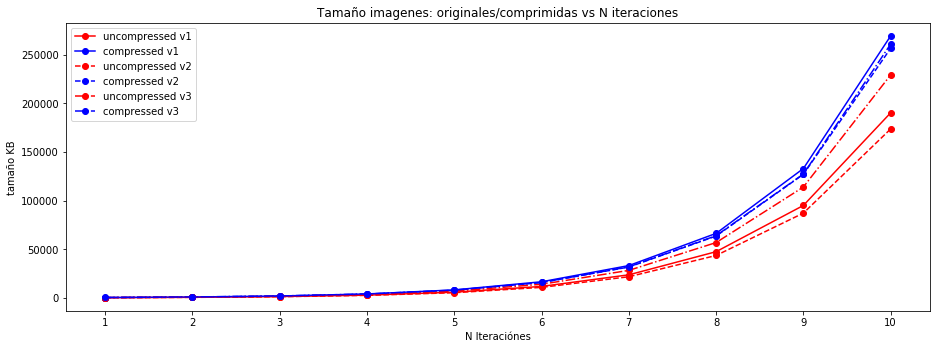

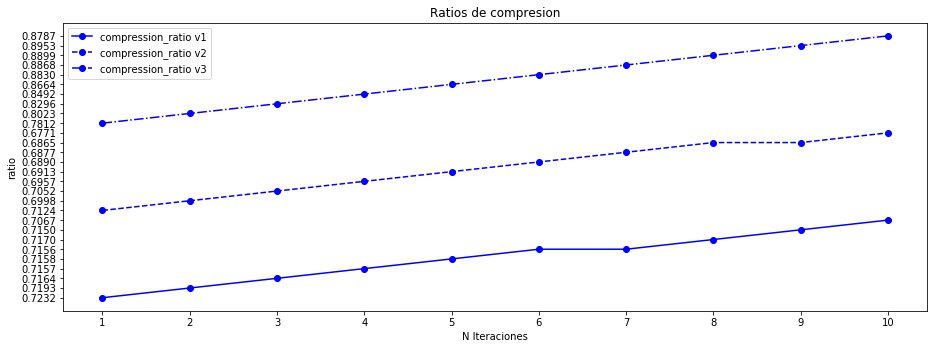

In [7]:
from matplotlib import pyplot as plt

%matplotlib inline
# x - numero de iteraciones
x = list(range(1, N_ITER+1))

# datos para video 1
u1 = uncompressed1
c1 = compressed1
z1 = []
for i in range(0,len(x)):
    if(u1[i]/c1[i] > 0):
        z1.append("{0:.4f}".format( u1[i]/c1[i]) )
    else:
        z1.append("{0:.4f}".format( c1[i]/u1[i]) )

# datos para video 2
u2 = uncompressed2
c2 = compressed2
z2 = []
for i in range(0,len(x)):
    if(u2[i]/c2[i] > 0):
        z2.append("{0:.4f}".format( u2[i]/c2[i]) )
    else:
        z2.append("{0:.4f}".format( c2[i]/u2[i]) )

# datos para video 3
u3 = uncompressed3
c3 = compressed3
z3 = []
for i in range(0,len(x)):
    if(u3[i]/c3[i] > 0):
        z3.append("{0:.4f}".format( u3[i]/c3[i]) )
    else:
        z3.append("{0:.4f}".format( c3[i]/u3[i]) )


print('-----------------------------------------------------------------------------------------------------------------------')
print('ITERATIONS')
print(str(x))
print('SIZE IN: %s' %SIZE_SUFFIX)
print('UNCOMPRESSED')
print('v1: ' + str(u1))
print('v2: ' + str(u2))
print('v3: ' + str(u3))
print('COMPRESSED')
print('v1: ' + str(c1))
print('v2: ' + str(c2))
print('v3: ' + str(c3))
print('COMPRESSION RATIO')
print('v1: ' + str(z1))
print('v2: ' + str(z2))
print('v3: ' + str(z3))
print('-----------------------------------------------------------------------------------------------------------------------')

fig1=plt.figure()
ax=fig1.add_axes([0,0,2,1])
ax.set_title("Tamaño imagenes: originales/comprimidas vs N iteraciones")
ax.set_xlabel("N Iteraciónes")
ax.set_ylabel("tamaño %s" %SIZE_SUFFIX)
ax.set_xticks(x)
#ax.set_yticks(u1+c1)
ax.plot(x,u1,'-bo',color='r',label='uncompressed v1', linestyle='-')
ax.plot(x,c1,'-bo',color='b',label='compressed v1', linestyle='-')
ax.plot(x,u2,'-bo',color='r',label='uncompressed v2', linestyle='--')
ax.plot(x,c2,'-bo',color='b',label='compressed v2', linestyle='--')
ax.plot(x,u3,'-bo',color='r',label='uncompressed v3', linestyle='-.')
ax.plot(x,c3,'-bo',color='b',label='compressed v3', linestyle='-.')
ax.legend(loc="upper left")

fig2=plt.figure()
ax1=fig2.add_axes([0,0,2,1])
ax1.set_title('Ratios de compresion')
ax1.set_xlabel("N Iteraciones")
ax1.set_ylabel("ratio")
ax1.set_xticks(x)
ax1.plot(x,z1,'-bo',color='b', label='compression_ratio v1', linestyle='-')
ax1.plot(x,z2,'-bo',color='b', label='compression_ratio v2', linestyle='--')
ax1.plot(x,z3,'-bo',color='b', label='compression_ratio v3', linestyle='-.')
ax1.legend(loc="upper left")